# TOI-141 Radial Velocities: Nested Sampling and Comparison with Juliet

In this notebook, we will analyze the RV observations of TOI-141 presented in [Espinoza et al. (2019)](https://arxiv.org/abs/1903.07694).
In doing so, we aim to reproduce the ["Fitting radial-velocities" tutorial from the juliet package](https://juliet.readthedocs.io/en/latest/tutorials/rvfits.html) analyzing the same data.
This should provide users a good entry point to convert code from one library to anoter in addition to demonstrating the nested sampling interface in RadVel.

In [1]:
from pandas import read_csv
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

import radvel

plt.style.use("tableau-colorblind10")

/home/vandal/miniforge3/envs/radvel/lib/python3.10/site-packages/docutils/utils/code_analyzer.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound as ResourceError


## The Data

Let us first load the data. We added the data from Juliet to RadVel's example data directory (`radvel.DATADIR`) so they are easily accessible.

In [2]:
data_df = read_csv(os.path.join(radvel.DATADIR, "rvs_toi141.dat"), sep=" ", names=["t", "rv", "erv", "inst"])
t, vel, errvel, inst = data_df.t.values, data_df.rv.values, data_df.erv.values, data_df.inst.values
min_time = np.min(t[inst == "FEROS"]) - 30.0
max_time = np.max(t[inst == "FEROS"]) + 30.0
t_mod = np.linspace(min_time, max_time, 1000)

inst_groups = data_df.groupby("inst").groups
inst_names = list(inst_groups.keys())

T_OFF = 2457000.0

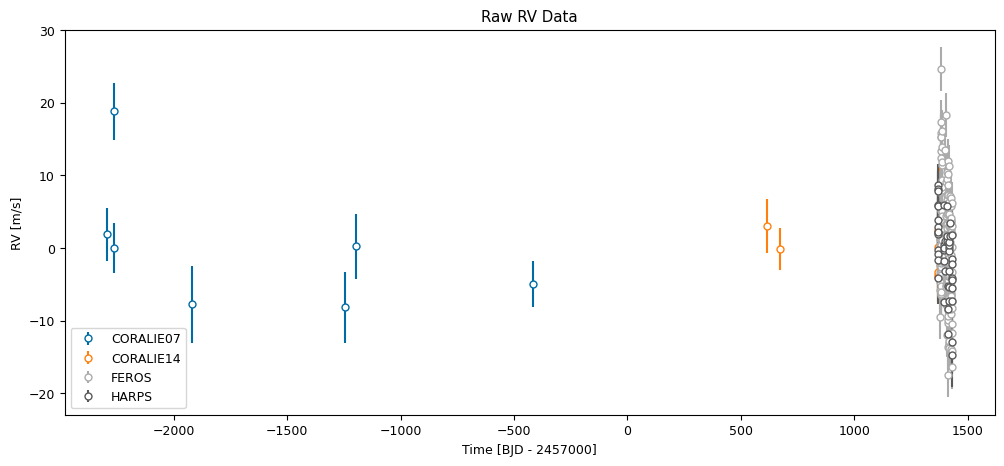

In [3]:
def plot_data(t, vel, errvel, post=None, instruments=None):
    fig = plt.figure(figsize=(12, 5))
    instruments =  instruments or ["FEROS", "HARPS"]
    for inst in instruments:
        inds = inst_groups[inst]
        if post is not None:
            vel = vel - post.params[f"gamma_{inst}"].value
            errvel_inflated = np.sqrt(errvel**2 + post.params[f"jit_{inst}"].value**2)
        plt.errorbar(t[inds] - T_OFF, vel[inds], yerr=errvel[inds], fmt="o", label=inst, mfc="w")
        if post is not None:
            plt.errorbar(t[inds] - T_OFF, vel[inds], yerr=errvel_inflated[inds], fmt="None", ecolor="r", capsize=0, zorder=-10)
    plt.ylabel("RV [m/s]")
    plt.xlabel(f"Time [BJD - {T_OFF:.0f}]")
    plt.legend()
    return fig

plot_data(t, vel, errvel, instruments=inst_names)
plt.title("Raw RV Data")
plt.show()

The CORALIE data is very sparse, so we will focus on the FEROS and HARPS data in these plots.

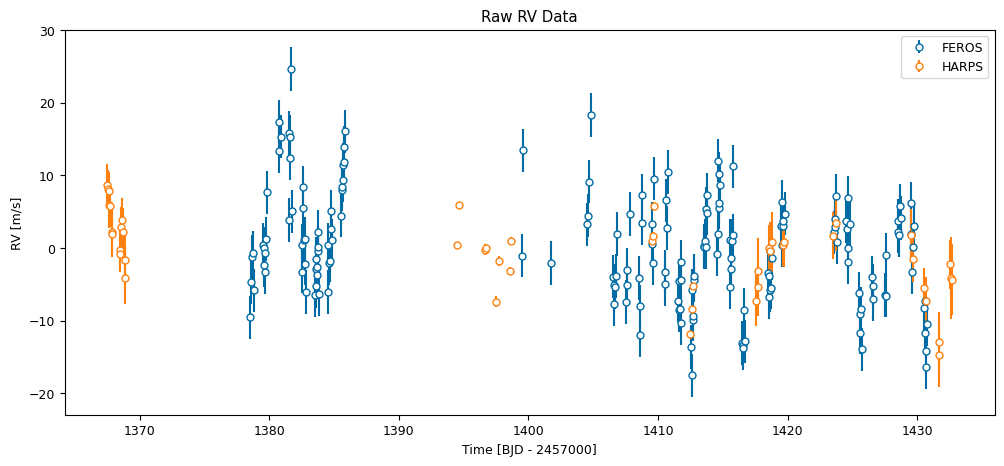

In [4]:
plot_data(t, vel, errvel)
plt.title("Raw RV Data")
plt.show()

## Single-Planet Model

We will start by fitting the transiting planet in the system.
The period and time of conjunction from transits are $P = 1.07917 \pm 0.000073$ days and $t_0 = 2458325.5386 \pm 0.0011$, respectively.
We can use these results as priors for the RV fit. We also assume circular orbits, so we fix `e` and `w` for all planets.

### RadVel model

Since this is a multi-instrument fit, we will need to define multiple likelihoods, all sharing the same physical `RVModel`.
We will have to re-build the model multiple times (for 1, 2 and 3 planets) so we create a "builder function".
The parameters are first initialized as point estimates.
Then one likelihood per instrument is set, and we make sure that each likelihood has access only to the data from one instrument.
Finally, we combine the likelihoods in a `CompositeLikelihood` object pass them to a `Posterior`.
We then add priors to the posterior objects for all free parameters.

In [5]:
def build_model(n_planets):
    params = radvel.Parameters(n_planets, basis="per tc e w k")

    P = 1.007917
    P_err = 0.000073
    t0 = 2458325.5386
    t0_err = 0.0011
    params["per1"] = radvel.Parameter(value=P)
    params["tc1"] = radvel.Parameter(value=t0)
    params["e1"] = radvel.Parameter(value=0.0, vary=False)
    params["w1"] = radvel.Parameter(value=90.0 * np.pi / 180.0, vary=False)
    params["k1"] = radvel.Parameter(value=10.0)
    params['dvdt'] = radvel.Parameter(value=0.,vary=False)
    params['curv'] = radvel.Parameter(value=0.,vary=False)
    if n_planets > 1:
        params["per2"] = radvel.Parameter(value=3.0)
        params["tc2"] = radvel.Parameter(value=2458325+2)
        params["e2"] = radvel.Parameter(value=0.0, vary=False)
        params["w2"] = radvel.Parameter(value=90.0 * np.pi / 180.0, vary=False)
        params["k2"] = radvel.Parameter(value=10.0)
    if n_planets > 2:
        params["per3"] = radvel.Parameter(value=10.0)
        params["tc3"] = radvel.Parameter(value=2458325+8)
        params["e3"] = radvel.Parameter(value=0.0, vary=False)
        params["w3"] = radvel.Parameter(value=90.0 * np.pi / 180.0, vary=False)
        params["k3"] = radvel.Parameter(value=10.0)

    model = radvel.RVModel(params)

    likes = []
    for inst in inst_names:
        indices = inst_groups[inst]
        like_inst = radvel.RVLikelihood(model, t[indices], vel[indices], errvel[indices], suffix=f"_{inst}")
        like_inst.params['gamma_'+inst] = radvel.Parameter(value=np.mean(vel[indices]), vary=True)
        like_inst.params['jit_'+inst] = radvel.Parameter(value=np.mean(errvel[indices]), vary=True)
        likes.append(like_inst)

    like = radvel.CompositeLikelihood(likes)

    post = radvel.posterior.Posterior(like)

    post.priors += [radvel.prior.Gaussian("per1", P, P_err)]
    post.priors += [radvel.prior.Gaussian("tc1", t0, t0_err)]
    post.priors += [radvel.prior.HardBounds("gamma_CORALIE14", -100.0, 100.0)]
    post.priors += [radvel.prior.HardBounds("gamma_CORALIE07", -100.0, 100.0)]
    post.priors += [radvel.prior.HardBounds("gamma_HARPS", -100.0, 100.0)]
    post.priors += [radvel.prior.HardBounds("gamma_FEROS", -100.0, 100.0)]
    post.priors += [radvel.prior.HardBounds("k1", 0.0, 100.0)]
    post.priors += [radvel.prior.Jeffreys("jit_CORALIE14", 1e-3, 100.0)]
    post.priors += [radvel.prior.Jeffreys("jit_CORALIE07", 1e-3, 100.0)]
    post.priors += [radvel.prior.Jeffreys("jit_HARPS", 1e-3, 100.0)]
    post.priors += [radvel.prior.Jeffreys("jit_FEROS", 1e-3, 100.0)]
    if n_planets > 1:
        post.priors += [radvel.prior.HardBounds("per2", 1.0, 10.0)]
        post.priors += [radvel.prior.HardBounds("tc2", 2458325.0, 2458330.0)]
        post.priors += [radvel.prior.HardBounds("k2", 0.0, 100.0)]
    if n_planets > 2:
        post.priors += [radvel.prior.HardBounds("per3", 1.0, 40.0)]
        post.priors += [radvel.prior.HardBounds("tc3", 2458325.0, 2458355.0)]
        post.priors += [radvel.prior.HardBounds("k3", 0.0, 100.0)]
    return post

In [6]:
post_single = build_model(1)
print(post_single)

parameter                     value      vary
per1                        1.00792       True
tc1                     2.45833e+06       True
e1                                0      False
w1                           1.5708      False
k1                               10       True
dvdt                              0      False
curv                              0      False
gamma_CORALIE07          0.00285714       True
jit_CORALIE07               4.11286       True
gamma_CORALIE14             0.30625       True
jit_CORALIE14               3.47625       True
gamma_FEROS                -0.08125       True
jit_FEROS                         3       True
gamma_HARPS               -0.857872       True
jit_HARPS                   2.59574       True
tp1                     2.45833e+06           

Priors
------
Gaussian prior on per1, mu=1.007917, sigma=7.3e-05
Gaussian prior on tc1, mu=2458325.5386, sigma=0.0011
Bounded prior on gamma_CORALIE14, min=-100.0, max=100.0
Bounded prior on gamma_CORA

Note that because we are using nested sampling, we absolutely need _proper_ priors for all parameters.
This will be checked internally in the `radvel.nested_sampling` module, but we can check manually.
The function below will return an error if one of the parameters has no priors.

In [7]:
post_single.check_proper_priors()

### MAP Estimate

Before diving into a nested sampling analysis, let us take a quick look at what the maximum a posteriori (MAP) result looks like.


In [8]:
res = optimize.minimize(
    post_single.neglogprob_array, post_single.get_vary_params(), method='Nelder-Mead',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
post_single.set_vary_params(res.x)

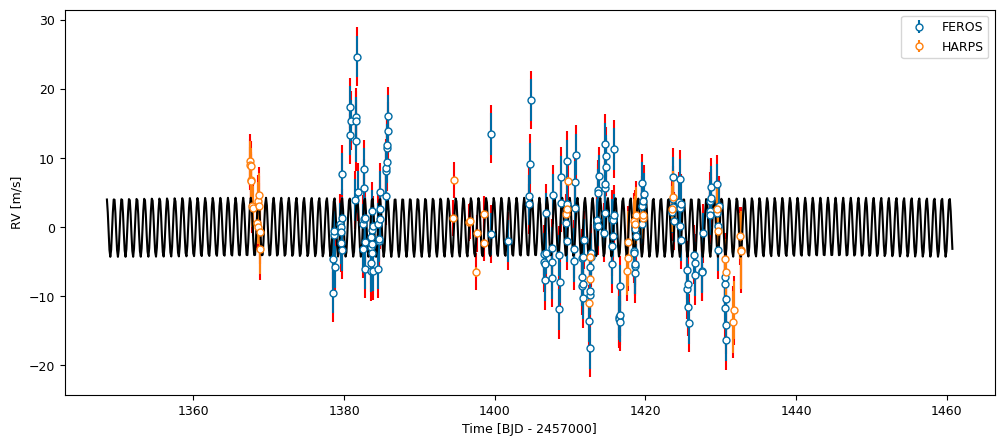

In [9]:
plot_data(t, vel, errvel, post=post_single)
plt.plot(t_mod - T_OFF, post_single.model(t_mod), "k", label="Keplerian fit")
plt.show()

### Nested Sampling

This looks pretty good, but we do not have the posterior distribution for our paramters, nor the Bayesian evidence.
We can obtain both of these with nested sampling.
RadVel supports several nested sampling libraries in its `radvel.nested_sampling.run()` function.
This `run()` function is fairly simple. It calls `Posterior.likelihood_ns_array()` and `Posterior.prior_transform()` and passes them to the selected sampling package.
See the [All samplers tutorial](./docs/tutorials/k2_24_demo_all_samplers.ipynb) for a full list of supported samplers.

For this example, we will use [PyMultiNest](https://github.com/JohannesBuchner/PyMultiNest/), since it is used in the Juliet tutorial.
By default, we only need to pass the `Posterior` object `post_single` to the sampling function.
Extra arguments in `run_kwargs` are passed directly to `pymultinest.run()`. Here we use 300 live points and `resume=False` to make sure that the sampling runs from scratch and that no results saved on disk are re-used.
The multinest interface returns a `results` dictionary with three elements:

- `lnZ`: The Bayesian Evidence
- `lnZerr`: The statistical uncertainty on the Bayesian Evidence
- `samples`: The equally-weighted posterior samples. Here, "equally-weighted" means that the raw nested sampling samples were re-weighted to be equivalent to MCMC samples. The samples also include log-posterior values under `lnprobability`, for consistency with the MCMC interface.

In the cell below, we discard the last dimension of the samples as it contains log-likelihood values, which we are not interested in.

In [10]:
from radvel import nested_sampling

results_single = nested_sampling.run(post_single, sampler="multinest", run_kwargs={"n_live_points": 300, "resume": False})
samples_single = results_single["samples"].values[:, :-1]

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  300
 dimensionality =   11
 *****************************************************
  analysing data from tmpdir/out.txt ln(ev)=  -801.91095814404855      +/-  0.29125899706536856     
 Total Likelihood Evaluations:        78140
 Sampling finished. Exiting MultiNest



And finally, we can display the fit from our posterior median along with the data.

parameter                     value      vary
per1                        1.00797       True
tc1                     2.45833e+06       True
e1                                0      False
w1                           1.5708      False
k1                            3.847       True
dvdt                              0      False
curv                              0      False
gamma_CORALIE07           -0.201367       True
jit_CORALIE07               8.45803       True
gamma_CORALIE14            -1.72098       True
jit_CORALIE14               0.36412       True
gamma_FEROS                0.485077       True
jit_FEROS                    6.2051       True
gamma_HARPS               -0.102919       True
jit_HARPS                   3.61837       True
tp1                     2.45833e+06           

Priors
------
Gaussian prior on per1, mu=1.007917, sigma=7.3e-05
Gaussian prior on tc1, mu=2458325.5386, sigma=0.0011
Bounded prior on gamma_CORALIE14, min=-100.0, max=100.0
Bounded prior on gamma_CORA

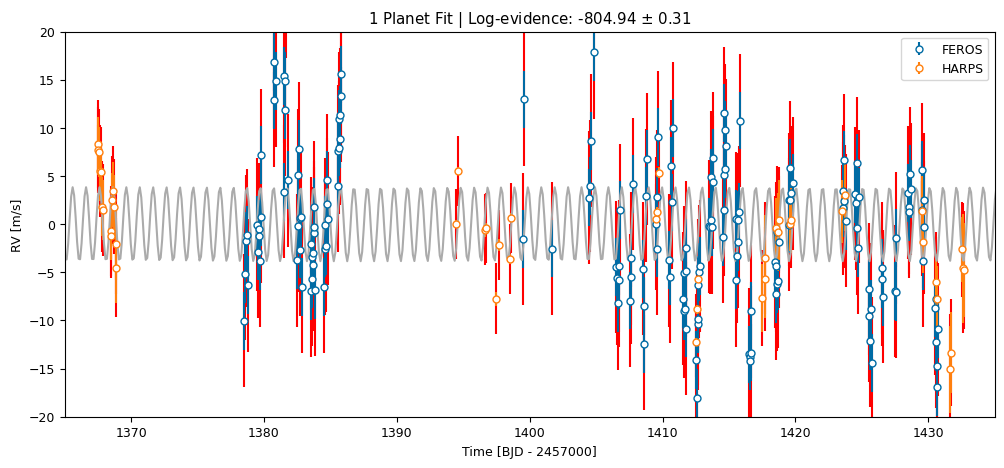

In [11]:
med_params = np.median(samples_single, axis=0)
post_single.set_vary_params(med_params)
print(post_single)

plot_data(t, vel, errvel, post=post_single)
plt.plot(t_mod - T_OFF, post_single.model(t_mod))
plt.ylim([-20,20])
plt.xlim([1365,1435])
plt.title(f"1 Planet Fit | Log-evidence: {results_single['lnZ']:.2f} $\pm$ {results_single['lnZerr']:.2f}")
plt.show()

We note two things here:

- The evidence is consistent with the results from [juliet](https://juliet.readthedocs.io/en/latest/tutorials/rvfits.html#rv-fits), which is nice!
- The "extra jitter" terms inflate the error bars for both instruments quite a bit, suggesting that there is unaccounted for signal (or noise) in the data.

We will further investigate that second bullet point by adding a second planet to the model.

## Two-Planet Model

The steps for a two-planet model are the exact same as with the one-planet model, except that we now pass `2` to ou model-building function.

We again start by taking a look at the MAP fit.

In [12]:
post_two = build_model(2)
print(post_two)

parameter                     value      vary
per1                        1.00792       True
tc1                     2.45833e+06       True
e1                                0      False
w1                           1.5708      False
k1                               10       True
per2                              3       True
tc2                     2.45833e+06       True
e2                                0      False
w2                           1.5708      False
k2                               10       True
dvdt                              0      False
curv                              0      False
gamma_CORALIE07          0.00285714       True
jit_CORALIE07               4.11286       True
gamma_CORALIE14             0.30625       True
jit_CORALIE14               3.47625       True
gamma_FEROS                -0.08125       True
jit_FEROS                         3       True
gamma_HARPS               -0.857872       True
jit_HARPS                   2.59574       True
tp1           

In [13]:
res = optimize.minimize(
    post_two.neglogprob_array, post_two.get_vary_params(), method='Nelder-Mead',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
post_two.set_vary_params(res.x)

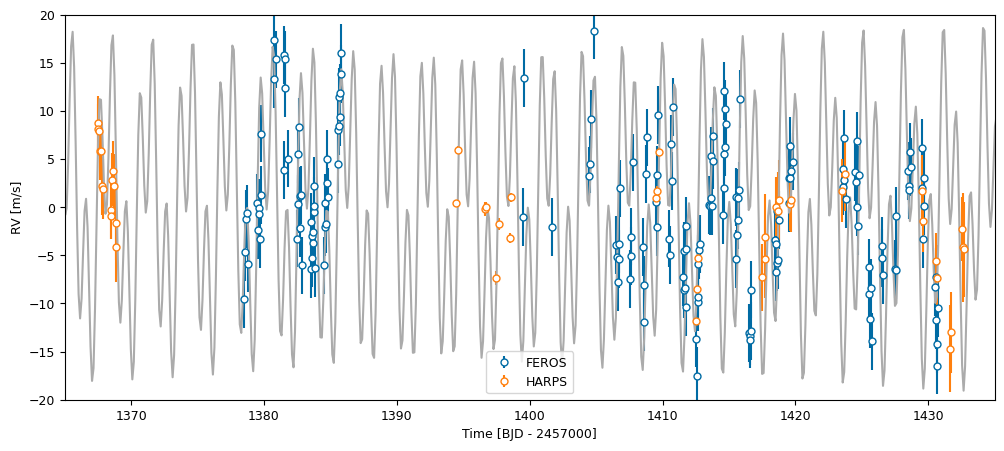

In [14]:
plot_data(t, vel, errvel)
plt.plot(t_mod - T_OFF, post_two.model(t_mod))
plt.ylim([-20,20])
plt.xlim([1365,1435])
plt.show()

This already looks like it has a better chance of capturing all the variability in the data.
Let us see what nested sampling tells us.

In [15]:
results_two = nested_sampling.run(post_two, sampler="multinest", run_kwargs={"n_live_points": 300, "resume": False})
samples_two = results_two["samples"].values[:, :-1]

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  300
 dimensionality =   14
 *****************************************************

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging toward

In [16]:
med_params = np.median(samples_two, axis=0)
post_two.set_vary_params(med_params)
print(post_two)

parameter                     value      vary
per1                        1.00803       True
tc1                     2.45833e+06       True
e1                                0      False
w1                           1.5708      False
k1                          5.17357       True
per2                        4.78412       True
tc2                     2.45833e+06       True
e2                                0      False
w2                           1.5708      False
k2                          7.05777       True
dvdt                              0      False
curv                              0      False
gamma_CORALIE07           -0.123356       True
jit_CORALIE07               2.92335       True
gamma_CORALIE14            -2.30928       True
jit_CORALIE14             0.0339858       True
gamma_FEROS                0.436888       True
jit_FEROS                   2.46208       True
gamma_HARPS                0.601128       True
jit_HARPS                   1.86251       True
tp1           

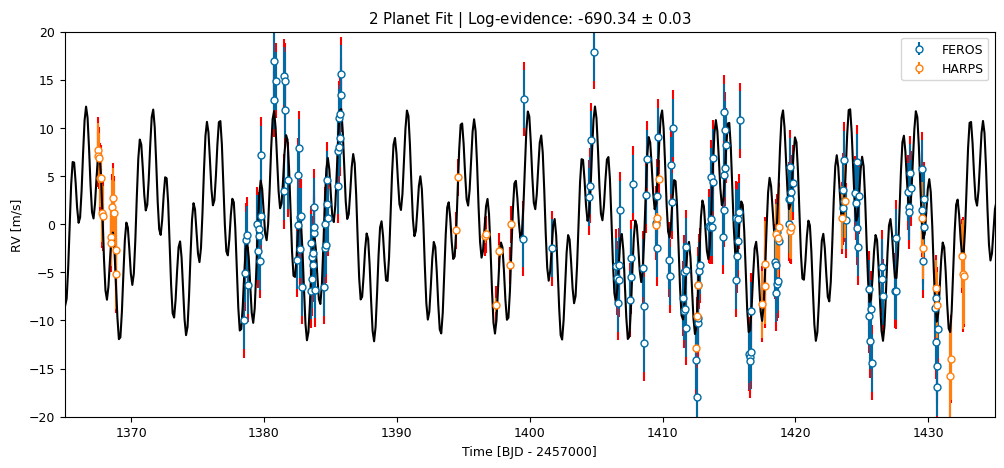

In [17]:
plot_data(t, vel, errvel, post=post_two)
plt.plot(t_mod - T_OFF, post_two.model(t_mod), "k")
plt.ylim([-20,20])
plt.xlim([1365,1435])
plt.title(f"2 Planet Fit | Log-evidence: {results_two['lnZ']:.2f} $\pm$ {results_two['lnZerr']:.2f}")
plt.show()

This all looks much better!
Notice that the "extra jitter" terms are now smaller, and the fit looks like a closer match to the data.
We can also calculate the $\Delta \ln Z$ to get a quantitative estimate of the odds ratio between the two models.


In [18]:
delta_lnZ_21 = results_two["lnZ"] - results_single["lnZ"]
print(f"Evidence one planet: {results_single['lnZ']:.2f} +/- {results_single['lnZerr']:.2f}")
print(f"Evidence two planet: {results_two['lnZ']:.2f} +/- {results_two['lnZerr']:.2f}")
print(f"Difference (2 - 1): {delta_lnZ_21:.2f}")

Evidence one planet: -804.94 +/- 0.31
Evidence two planet: -690.34 +/- 0.03
Difference (2 - 1): 114.60


As we can see above, the evidence is extremely strong in favor of the two-planet model.

Since nested sampling also gives us the posterior distribution, we can take a look at the posterior samples for parameters of interest.

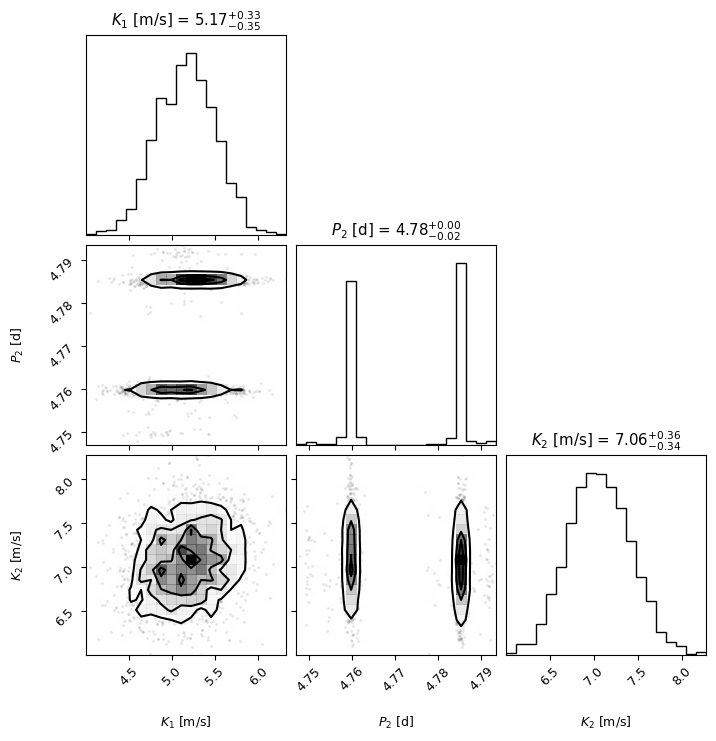

In [19]:
n_params = len(post_two.name_vary_params())
show_names = ["k1", "per2", "k2"]
show_idx = [i for i, name in enumerate(post_two.name_vary_params()) if name in show_names]
show_labels = ["$K_1$ [m/s]", "$P_2$ [d]", "$K_2$ [m/s]"]

import corner
corner.corner(samples_two[:, show_idx], labels=show_labels, show_titles=True)
plt.show()

The bimodality for $P_2$ is caused by an alias of the period.
This is discussed in the [Joint transit and radial-velocity fits](https://juliet.readthedocs.io/en/latest/tutorials/jointfits.html#jointfits) tutorial of Juliet and in the [Espinoza et al. (2019)](https://arxiv.org/abs/1903.07694) paper.
Please take a look at these references if you want to learn more!

## Three-Planet Model

There is still some unexplained variation in the data (the jitter terms are non-zero).
Let us explore if this can be explained by adding a third planet.

In [20]:
post_three = build_model(3)

res = optimize.minimize(
    post_three.neglogprob_array, post_three.get_vary_params(), method='Nelder-Mead',
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
post_three.set_vary_params(res.x)
print(post_three)

parameter                     value      vary
per1                        1.00786       True
tc1                     2.45833e+06       True
e1                                0      False
w1                           1.5708      False
k1                          9.99997       True
per2                        3.00049       True
tc2                     2.45833e+06       True
e2                                0      False
w2                           1.5708      False
k2                               10       True
per3                        10.1235       True
tc3                     2.45833e+06       True
e3                                0      False
w3                           1.5708      False
k3                          10.0001       True
dvdt                              0      False
curv                              0      False
gamma_CORALIE07          0.00285717       True
jit_CORALIE07               4.11288       True
gamma_CORALIE14            0.306249       True
jit_CORALIE14 

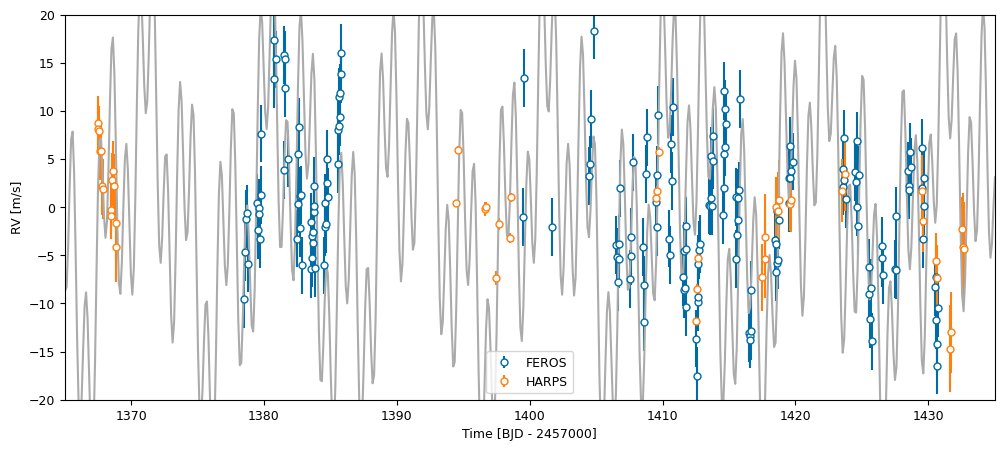

In [21]:
plot_data(t, vel, errvel)
plt.plot(t_mod - T_OFF, post_three.model(t_mod))
plt.ylim([-20,20])
plt.xlim([1365,1435])
plt.show()

In [22]:
results_three = nested_sampling.run(post_three, sampler="multinest", run_kwargs={"n_live_points": 300, "resume": False})
samples_three = results_three["samples"].values[:, :-1]

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  300
 dimensionality =   17
 *****************************************************

 MultiNest Warning!
 Parameter            9  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.
 Parameter            9  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.
 Parameter            9  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            6  of mode            1  is converging towards the edge of the prior.
 Parameter            9  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter       

In [26]:
med_params = np.median(samples_three, axis=0)
post_three.set_vary_params(med_params)
print(post_three)

parameter                     value      vary
per1                        1.00803       True
tc1                     2.45833e+06       True
e1                                0      False
w1                           1.5708      False
k1                          5.14401       True
per2                        4.75979       True
tc2                     2.45833e+06       True
e2                                0      False
w2                           1.5708      False
k2                          6.94346       True
per3                        5.94863       True
tc3                     2.45834e+06       True
e3                                0      False
w3                           1.5708      False
k3                          1.09858       True
dvdt                              0      False
curv                              0      False
gamma_CORALIE07            -0.25045       True
jit_CORALIE07               3.28259       True
gamma_CORALIE14            -2.49657       True
jit_CORALIE14 

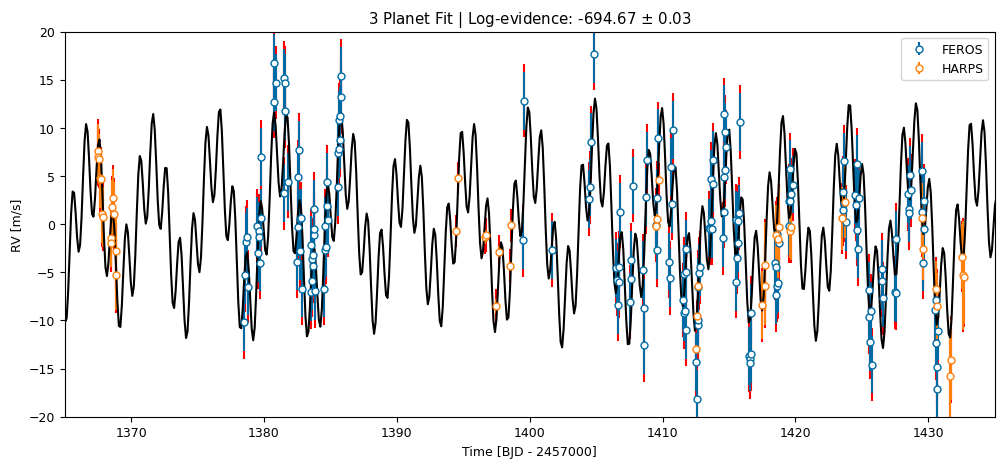

In [27]:
plot_data(t, vel, errvel, post=post_three)
plt.plot(t_mod - T_OFF, post_three.model(t_mod), "k")
plt.ylim([-20,20])
plt.xlim([1365,1435])
plt.title(f"3 Planet Fit | Log-evidence: {results_three['lnZ']:.2f} $\pm$ {results_three['lnZerr']:.2f}")
plt.show()

In [28]:
print(f"Evidence one planet: {results_single['lnZ']:.2f} +/- {results_single['lnZerr']:.2f}")
print(f"Evidence two planet: {results_two['lnZ']:.2f} +/- {results_two['lnZerr']:.2f}")
print(f"Evidence three planet: {results_three['lnZ']:.2f} +/- {results_three['lnZerr']:.2f}")

Evidence one planet: -804.94 +/- 0.31
Evidence two planet: -690.34 +/- 0.03
Evidence three planet: -694.67 +/- 0.03


As we can see, the evidence is stronger for the two-planet model and does not justify the inclusion of a third companion in the system.